# ECMA 31330 Final Project
### Abby Beckler, Miles Brown

In [91]:
# imports
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

## Load Data + Use KNN to Impute Missing Values

In [92]:
# set seed to ensure reproducibility
np.random.seed(25)

# load the data
ANES = pd.read_csv('data/ANES.csv')

# remove rows with missing 'pocket', 'retro', and 'trumpft' values
ANES = ANES.dropna(subset=['pocket', 'retro', 'trumpft'])

# impute using k-nearest neighbors imputer
imputer = KNNImputer(n_neighbors=5)
ANES = pd.DataFrame(imputer.fit_transform(ANES), columns=ANES.columns)

# add relevant columns 'pocketEval' and 'econEval'
ANES['pocketEval'] = (ANES['pocket'] - 3) * (-1/2)
ANES['econEval'] = (ANES['retro'] - 3) * (-1/2)

## Perform Initial OLS Regressions (same as K&K)

In [93]:
# isolate the independent and dependent variables
X_pocket = ANES[['pocketEval']]
X_econ = ANES[['econEval']]
X_ols = ANES[['pocketEval', 'econEval']]

# Quick correlation test between pocketEval and econEval
correlation = ANES[['pocketEval', 'econEval']].corr()
print(correlation) # Low positive correlation indicating they don't measure the same thing


y = ANES['trumpft']

# run the OLS regression for the pocket and econ evaluations
X_ols = sm.add_constant(X_ols)
model_ols = sm.OLS(y, X_ols).fit()
print(model_ols.summary())

# export the results to a .tex file
with open('outputs/ols_results.tex', 'w') as tf:
    tf.write(model_ols.summary().as_latex())


            pocketEval  econEval
pocketEval    1.000000  0.228858
econEval      0.228858  1.000000
                            OLS Regression Results                            
Dep. Variable:                trumpft   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     1939.
Date:                Sat, 15 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:45:40   Log-Likelihood:                -39332.
No. Observations:                7998   AIC:                         7.867e+04
Df Residuals:                    7995   BIC:                         7.869e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

## More Complex OLS Regressions (+ Covariates)

In [ ]:
# create list of covariate columns
covariates = ANES.columns.tolist()
removed = ['trumpft', 'trumpft_post', 'pocket', 'retro', 'pocketEval', 'econEval', 'votepres',
           'bidenft', 'bidenft_post', 'pid_lean', 'pid_strong', 'pid3', 'pid7']
for col in removed:
    covariates.remove(col)

# run the OLS regression for the simultaneous pocket and econ evaluations with the covariates
regression_cols = ['pocketEval', 'econEval'] + covariates
X_ols_covs = ANES[regression_cols]
X_ols_covs = sm.add_constant(X_ols_covs)
model_ols_covs = sm.OLS(y, X_ols_covs).fit()
print(model_ols_covs.summary())

# export the results to a .tex file
with open('outputs/ols_covs_results.tex', 'w') as tf:
    tf.write(model_ols_covs.summary().as_latex())

                            OLS Regression Results                            
Dep. Variable:                trumpft   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1153.
Date:                Sat, 15 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:45:40   Log-Likelihood:                -32617.
No. Observations:                7998   AIC:                         6.533e+04
Df Residuals:                    7949   BIC:                         6.567e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   35.5316 

## Train/Test Split

In [95]:
# define X pocket_cov and X econ_cov
X_pocket_cov = ANES[['pocketEval'] + covariates]
X_econ_cov = ANES[['econEval'] + covariates]

# train test split the pocket and econ + covariate data
X_pocket_cov_train, X_pocket_cov_test, y_train_pocket, y_test_pocket = train_test_split(X_pocket_cov, y, test_size=0.2, random_state=25)
X_econ_cov_train, X_econ_cov_test, y_train_econ, y_test_econ = train_test_split(X_econ_cov, y, test_size=0.2, random_state=25)

# standardize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
X_pocket_cov_train = scaler.fit_transform(X_pocket_cov_train)
X_pocket_cov_test = scaler.transform(X_pocket_cov_test)
X_econ_cov_train = scaler.fit_transform(X_econ_cov_train)
X_econ_cov_test = scaler.transform(X_econ_cov_test)

# Put back into a pandas dataframe
X_pocket_cov_train = pd.DataFrame(X_pocket_cov_train, columns=X_pocket_cov.columns)
X_pocket_cov_test = pd.DataFrame(X_pocket_cov_test, columns=X_pocket_cov.columns)
X_econ_cov_train = pd.DataFrame(X_econ_cov_train, columns=X_econ_cov.columns)
X_econ_cov_test = pd.DataFrame(X_econ_cov_test, columns=X_econ_cov.columns)

scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_pocket = scaler_y.fit_transform(y_train_pocket.values.reshape(-1, 1))
y_test_pocket = scaler_y.transform(y_test_pocket.values.reshape(-1, 1))
y_train_econ = scaler_y.fit_transform(y_train_econ.values.reshape(-1, 1))
y_test_econ = scaler_y.transform(y_test_econ.values.reshape(-1, 1))

y_train_pocket = pd.DataFrame(y_train_pocket, columns=['trumpft'])
y_test_pocket = pd.DataFrame(y_test_pocket, columns=['trumpft'])
y_train_econ = pd.DataFrame(y_train_econ, columns=['trumpft'])
y_test_econ = pd.DataFrame(y_test_econ, columns=['trumpft'])
#'''


## LASSO Regression

In [96]:

# fit LASSO models
lasso_pocket = Lasso(alpha=0.05, random_state=25)
lasso_pocket.fit(X_pocket_cov_train, y_train_pocket)

lasso_econ = Lasso(alpha=0.05, random_state=25)
lasso_econ.fit(X_econ_cov_train, y_train_econ)

# predict the test set
y_pred_pocket = lasso_pocket.predict(X_pocket_cov_test)
y_pred_econ = lasso_econ.predict(X_econ_cov_test)

# print the intercept, number of nonzero coefficients, and the names of nonzero coefficients
print('Lasso Pocket Model:')
print('Intercept:', lasso_pocket.intercept_)
print('Number of Nonzero Coefficients:', np.count_nonzero(lasso_pocket.coef_))
print('Nonzero Coefficients:', X_pocket_cov.columns[lasso_pocket.coef_ != 0].tolist())
print('Accuracy:', r2_score(y_test_pocket, y_pred_pocket))

print('\nLasso Econ Model:')
print('Intercept:', lasso_econ.intercept_)
print('Number of Nonzero Coefficients:', np.count_nonzero(lasso_econ.coef_))
print('Nonzero Coefficients:', X_econ_cov.columns[lasso_econ.coef_ != 0].tolist())
print('Accuracy:', r2_score(y_test_econ, y_pred_econ))




Lasso Pocket Model:
Intercept: [-0.02034677]
Number of Nonzero Coefficients: 8
Nonzero Coefficients: ['envir_business', 'covid_approval', 'mail_in_attitude', 'repro', 'ideology', 'trans', 'immigration', 'gun_diff']
Accuracy: 0.8543858395871623

Lasso Econ Model:
Intercept: [-0.02031254]
Number of Nonzero Coefficients: 9
Nonzero Coefficients: ['econEval', 'envir_business', 'covid_approval', 'mail_in_attitude', 'repro', 'ideology', 'trans', 'immigration', 'gun_diff']
Accuracy: 0.8543833698545613


## Neural Network (?)

In [97]:
#
class ANESDataset(Dataset):
    '''Formats the dataset for the neural network'''
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ANESNet(nn.Module):
    '''Creates a neural network model with 3 hidden layers'''
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANESNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_dim = X_pocket_cov_train.shape[1]
hidden_dim = 100
output_dim = 1



def train_model(X_train_model, y_train_model, X_test_model, y_test_model, input_dim, hidden_dim, output_dim, n_epochs=50):
    '''Creates and trains a neural network model given the data, the input and output dimensions, and the number of epochs'''
    anes_net = ANESNet(input_dim, hidden_dim, output_dim)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(anes_net.parameters(), lr=0.001)

    anes_train = ANESDataset(X_train_model, y_train_model)
    anes_test = ANESDataset(X_test_model, y_test_model)

    train_loader = DataLoader(anes_train, batch_size=64, shuffle=True)
    test_loader = DataLoader(anes_test, batch_size=64, shuffle=False)


    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        anes_net.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = anes_net(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        anes_net.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = anes_net(X_batch)
                loss = criterion(output, y_batch)
                test_loss += loss.item()
            print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Test Loss: {test_loss / len(test_loader)}')
            test_losses.append(test_loss / len(test_loader))
    return anes_net, test_loader


# Train the pocket eval model
input_dim = X_pocket_cov_train.shape[1]
anes_net_pocket, anes_loader = train_model(X_pocket_cov_train, y_train_pocket, X_pocket_cov_test, y_test_pocket, input_dim, hidden_dim, output_dim)

Epoch 1, Train Loss: 0.39457745909690856, Test Loss: 0.11676014751195908
Epoch 2, Train Loss: 0.19340961799025536, Test Loss: 0.089843370616436
Epoch 3, Train Loss: 0.15732367284595966, Test Loss: 0.08411342844367027
Epoch 4, Train Loss: 0.14100192502140999, Test Loss: 0.08445868209004402
Epoch 5, Train Loss: 0.1301916578412056, Test Loss: 0.08467676475644112
Epoch 6, Train Loss: 0.12660981878638267, Test Loss: 0.0831114773452282
Epoch 7, Train Loss: 0.12542599745094776, Test Loss: 0.08685723543167115
Epoch 8, Train Loss: 0.12130874387919903, Test Loss: 0.08626403644680977
Epoch 9, Train Loss: 0.12022503100335598, Test Loss: 0.08053894713521004
Epoch 10, Train Loss: 0.11490254774689675, Test Loss: 0.08456091955304146
Epoch 11, Train Loss: 0.11810235381126404, Test Loss: 0.08390209943056107
Epoch 12, Train Loss: 0.12052426375448703, Test Loss: 0.08432817950844765
Epoch 13, Train Loss: 0.11101614277809858, Test Loss: 0.08464387208223342
Epoch 14, Train Loss: 0.11083856727927924, Test Los

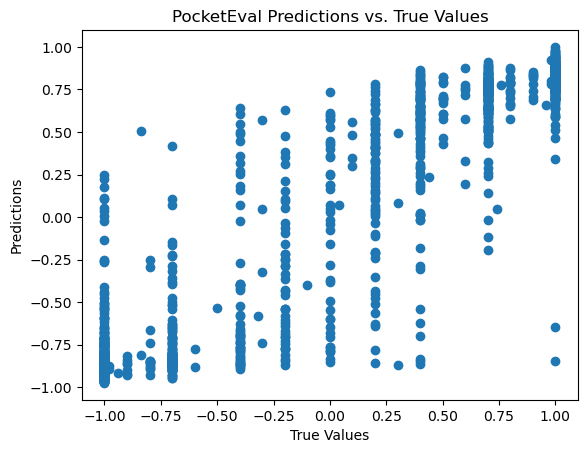

R^2 value for pocketEval model: 0.881340901540358
MSE for pocketEval model: 0.07727899608426889


In [98]:
# Show the predictions and mean squared error
anes_net_pocket.eval()
pocket_predictions = []
with torch.no_grad():
    for X_batch, y_batch in anes_loader:
        output = anes_net_pocket(X_batch)
        pocket_predictions.extend(output.numpy().flatten())

# plot the predictions vs. true values
plt.scatter(y_test_pocket, pocket_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('PocketEval Predictions vs. True Values')
plt.show()
y_test_pocket_graph = np.array(y_test_pocket)
pocket_predictions = np.array(pocket_predictions).reshape(-1, 1)
print('R^2 value for pocketEval model:', r2_score(y_test_pocket_graph, pocket_predictions))
print('MSE for pocketEval model:', np.mean((y_test_pocket_graph - pocket_predictions) ** 2))

In [99]:
# train a neural network on econEval model
input_dim = X_econ_cov_train.shape[1]
anes_net_econ, anes_loader = train_model(X_econ_cov_train, y_train_econ, X_econ_cov_test, y_test_econ, input_dim, hidden_dim, output_dim)

Epoch 1, Train Loss: 0.3849448277056217, Test Loss: 0.1008381462097168
Epoch 2, Train Loss: 0.1898269545286894, Test Loss: 0.08746827781200409
Epoch 3, Train Loss: 0.14432914435863495, Test Loss: 0.08701423808932304
Epoch 4, Train Loss: 0.13413152039051057, Test Loss: 0.08937623053789139
Epoch 5, Train Loss: 0.12852402195334434, Test Loss: 0.08691994637250901
Epoch 6, Train Loss: 0.12415719255805016, Test Loss: 0.08653881683945656
Epoch 7, Train Loss: 0.12030641660094261, Test Loss: 0.08386558905243874
Epoch 8, Train Loss: 0.11481926444917917, Test Loss: 0.08507157400250435
Epoch 9, Train Loss: 0.11644685696810483, Test Loss: 0.08290052443742751
Epoch 10, Train Loss: 0.11423983465880155, Test Loss: 0.08338205337524414
Epoch 11, Train Loss: 0.11202732931822539, Test Loss: 0.08547543987631798
Epoch 12, Train Loss: 0.11443056460469961, Test Loss: 0.08340145647525787
Epoch 13, Train Loss: 0.11063657522201538, Test Loss: 0.08605935618281364
Epoch 14, Train Loss: 0.10596626449376345, Test Lo

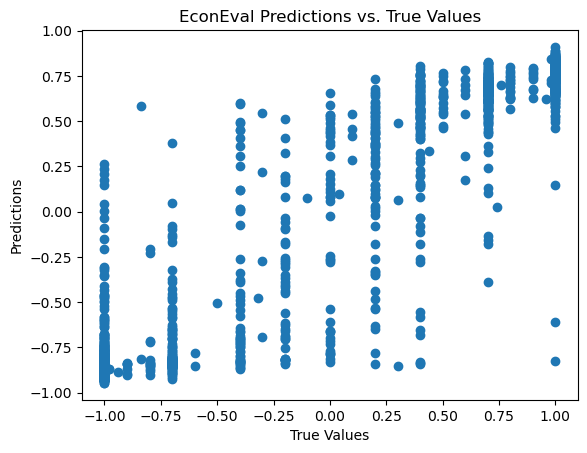

In [100]:
# Show the predictions and mean squared error for the econEval model
anes_net_econ.eval()
econ_predictions = []
with torch.no_grad():
    for X_batch, y_batch in anes_loader:
        output = anes_net_econ(X_batch)
        econ_predictions.extend(output.numpy().flatten())

# plot the predictions vs. true values
plt.scatter(y_test_econ, econ_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('EconEval Predictions vs. True Values')
plt.show()

y_test_econ = np.array(y_test_econ)
econ_predictions = np.array(econ_predictions).reshape(-1, 1)


In [101]:
#train a neural network on model without pocketEval and econEval
X_without_train = X_pocket_cov_train.drop(columns=['pocketEval'])
input_dim = X_without_train.shape[1]
X_without_test = X_pocket_cov_test.drop(columns=['pocketEval'])
anes_net_without, anes_loader = train_model(X_without_train, y_train_pocket, X_without_test, y_test_pocket, input_dim, hidden_dim, output_dim)

Epoch 1, Train Loss: 0.38424277529120443, Test Loss: 0.10405176728963852
Epoch 2, Train Loss: 0.20211494997143745, Test Loss: 0.08952540948987008
Epoch 3, Train Loss: 0.15226918317377566, Test Loss: 0.08589883476495742
Epoch 4, Train Loss: 0.13918150253593922, Test Loss: 0.08504931956529617
Epoch 5, Train Loss: 0.13349108070135116, Test Loss: 0.0840979640185833
Epoch 6, Train Loss: 0.12858392141759395, Test Loss: 0.08479026928544045
Epoch 7, Train Loss: 0.12748956434428693, Test Loss: 0.08491209149360657
Epoch 8, Train Loss: 0.12153553858399391, Test Loss: 0.08391253277659416
Epoch 9, Train Loss: 0.1178772858902812, Test Loss: 0.08535862922668457
Epoch 10, Train Loss: 0.11691631138324737, Test Loss: 0.08487013190984725
Epoch 11, Train Loss: 0.11313014168292285, Test Loss: 0.08473162949085236
Epoch 12, Train Loss: 0.11199137102812529, Test Loss: 0.0845879690349102
Epoch 13, Train Loss: 0.1156685384362936, Test Loss: 0.08186738893389701
Epoch 14, Train Loss: 0.11089970458298921, Test Los

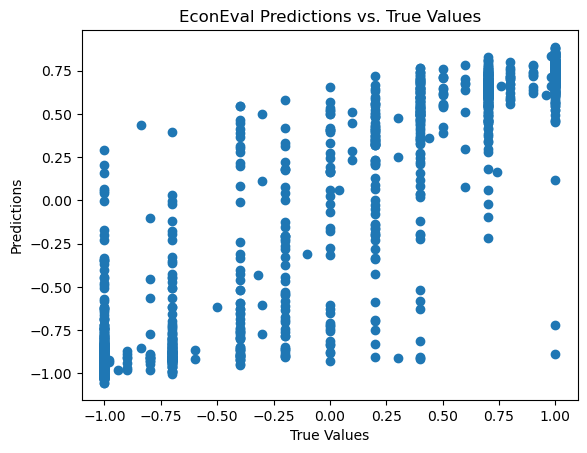

R^2 value for normal model: 0.8768147304382031
MSE for normal model: 0.08022675115253389


In [102]:
# Show the predictions and mean squared error for the model without pocketEval and econEval
anes_net_without.eval()
econ_predictions = []
with torch.no_grad():
    for X_batch, y_batch in anes_loader:
        output = anes_net_without(X_batch)
        econ_predictions.extend(output.numpy().flatten())

# plot the predictions vs. true values
plt.scatter(y_test_econ, econ_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('EconEval Predictions vs. True Values')
plt.show()

y_test_graph = np.array(y_test_econ)
econ_predictions = np.array(econ_predictions).reshape(-1, 1)
print('R^2 value for normal model:', r2_score(y_test_graph, econ_predictions))
print('MSE for normal model:', np.mean((y_test_graph - econ_predictions) ** 2))

## Random Forest

In [103]:
# run a Random Forest on pocketEval test data and covariates
rf_pocket = RandomForestRegressor(n_estimators=500, random_state=25)
y_train_pocket = y_train_pocket.values.ravel()
rf_pocket.fit(X_pocket_cov_train, y_train_pocket)

feature_importance_pocket = pd.DataFrame({
    "Feature": X_pocket_cov.columns,
    "Importance": rf_pocket.feature_importances_
}).sort_values(by="Importance", ascending=False)
feature_importance_pocket.head(10)

# get random forest prediction accuracy on pocket test
rf_pocket.score(X_pocket_cov_test, y_test_pocket)
print('Random Forest accuracy on pocketEval model:', rf_pocket.score(X_pocket_cov_test, y_test_pocket))

Random Forest accuracy on pocketEval model: 0.8851968120802028


In [104]:
# run a Random Forest on econEval and covariates
rf_econ = RandomForestRegressor(n_estimators=500, random_state=25)
y_train_econ = y_train_econ.values.ravel()
rf_econ.fit(X_econ_cov_train, y_train_econ)

feature_importance_econ = pd.DataFrame({
    "Feature": X_econ_cov.columns,
    "Importance": rf_econ.feature_importances_
}).sort_values(by="Importance", ascending=False)
feature_importance_econ.head(10)

# get random forest prediction accuracy on econ test
rf_econ.score(X_econ_cov_test, y_test_econ)
print('Random Forest accuracy on econEval model:', rf_econ.score(X_econ_cov_test, y_test_econ))

Random Forest accuracy on econEval model: 0.8853996721513752
